# One File With All Code of Every Milestone 

This file contains the optimal models that were obtained at the end of every milestone.

The code in this file was written by Brian Jakobs, Vera Eising, Joram Brokkelkamp and Damla Baspinar, with the purpose of making a first model for the Machine Learning Project Pawpularity in the Minor Artificial Intelligence at the University of Amsterdam.
This code was last modified at

## Import libraries for functions

In [ ]:
# Import the needed libraries
import os, random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Tensorflow 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, preprocessing, regularizers

# Google.colab drive import for image data
from google.colab import drive




# Import the data
Get the tabular data from github and the images from google.drive or drive of computer

In [ ]:
# Data from github
url = 'https://raw.githubusercontent.com/Veer56/Pawl_patrol/main/Code/data/train.csv'
train_data = pd.read_csv(url)

# Check for any Nan values in the train data, to find any missing values
train_data.isnull().values.any()

# Display an example of the tabular data
display(train_data.head(5))

# prompt for file location
print("How would you like to open the image data file?")
choice = int(input("To open the file via google drive enter '1', to open the file via a folder on your PC enter '2'. \n"))

# prompt for google drive path
if choice == 1:
    drive_path = input("Please specify the path to your petfinder-pawpularity-score.zip file. \n")

    path = '/content/gdrive'
    drive.mount(path)

    # unzip the file from the google drive
    !unzip "$drive_path"

# prompt for PC path
if choice == 2:
    pc_path = input("Please specify the path to the folder on your PC containing the train folder. \n")
    os.chdir(pc_path)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: train/7e3d6d03218db540c6125630572aa7cd.jpg  
  inflating: train/7e51d9305ec464c1f77cfee35ceb1b4f.jpg  
  inflating: train/7e56aa71d1e091e004703283323e8e7f.jpg  
  inflating: train/7e5d1650d5cda4d68f2ee8ce17c29b25.jpg  
  inflating: train/7e601feb12f2fb03c2d342e54cd47b1e.jpg  
  inflating: train/7e6ca633d2a751af58e1cc220ca519b3.jpg  
  inflating: train/7e717923c22053e51861a24aae701fb0.jpg  
  inflating: train/7e761f47cc1e3038a431f9f196234ab9.jpg  
  inflating: train/7e7921ed945c3c863882340360c9157d.jpg  
  inflating: train/7e8763e28a01c059b7a8d119c5ae0dc0.jpg  
  inflating: train/7e93691bef9bc381590cf004358ee11a.jpg  
  inflating: train/7e947e83394b6d74f1ec4f5b596bed6a.jpg  
  inflating: train/7e9d46bd87849a49ada5f2c336c9d929.jpg  
  inflating: train/7e9df6c36fd06411ce717d0ce761af35.jpg  
  inflating: train/7ea78b0c0bb036b1bbb76b99ec0b731c.jpg  
  inflating: train/7ead412443b3b7f598c53fbf9335caac.jpg  
  inflating: train

# Processing of Data

In this part of the notebook, all data will be processed in order to be used for the predictive model.

In [ ]:
def load_images_from_folder(folder, data = [], size=64):
    """ This function  takes image data in a given folder and resizes it to a 
    given size. It returns 5 arrays; one with the images, one with the 
    corresponding Pawpularity of every image, the names of the images, the 
    original width of the image and lastly the original height of the image """

    samples = len(data)    
    images = [None] * samples    
    width = [None] * samples
    height = [None] * samples
    
    # Use enumerate to keep track of the count and the files
    for count, filename in enumerate(os.listdir(folder)):

        # Remove the .jpg from the filenames
        name = filename.strip('.jpg')       
        

        # Keep track of the indices from the tabular data to sort the data
        index = train_data[train_data['Id']==name].index.item()
        img_original = cv2.imread(os.path.join(folder,filename))
        width[index] = img_original.shape[0]
        height[index] = img_original.shape[1]
        
        # Resize the images
        img = cv2.resize(img_original, (size, size))

        if img is not None:
            # Save the image in the right index
            images[index] = img

        # Keep count to see how the loading of the images progresses
        if count % 1000 == 0:                
          print(f"{round(count / samples *100, 0)}%")

    return np.array(images), np.array(data['Pawpularity']), np.array(data['Id']), width, height

# Use load_images_from_folder to load all images
images, image_labels, image_names, width, height = load_images_from_folder('train', data = train_data)

# Display the shapes of the images
print(f'Training labels loaded: {images.shape}')

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
61.0%
71.0%
81.0%
91.0%
Training labels loaded: (9912, 64, 64, 3)


# Data visualization

Random images

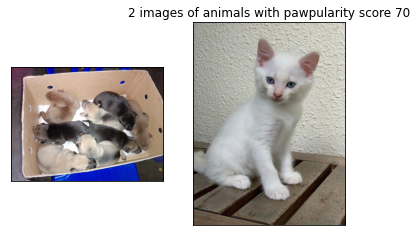

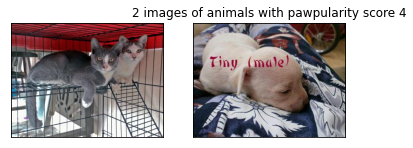

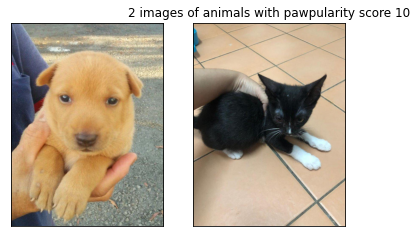

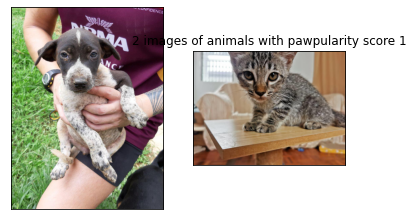

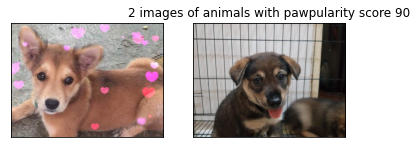

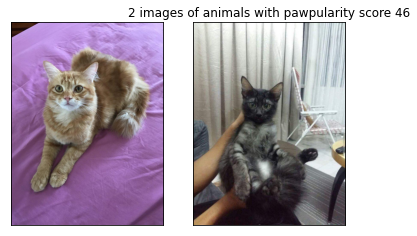

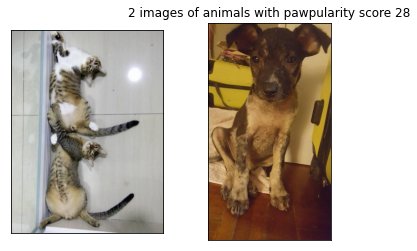

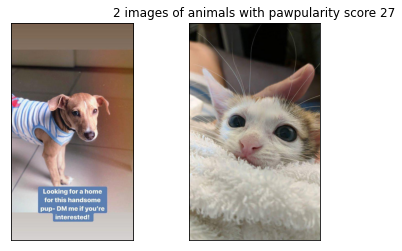

In [ ]:
def pick_image(data, folder, pawpularity, old_index):
  '''Takes the data file. the folder name the wanted pawpularity score and and 
  index of indexes with the same pawpularity score. It checks if the pawpularity
  score is the same as the ''' 
  score = -1
  while score != pawpularity:
      name = random.choice(os.listdir(folder))
      index = data[data['Id']==name.strip('.jpg')].index.item()
      if index not in old_index:
        
        score = data['Pawpularity'][index]
        old_index.append(index)
  
  img_original = cv2.imread(os.path.join("train",name))
  im_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
  return im_rgb, index

def pick_random_image(data, folder, amount = None, pawpularity = None):  

  if amount == None:
    amount = random.randint(1, 4)
  if pawpularity == None:
    pawpularity = random.randint(0, 100)
 
  top_list =  []
  old_index = []
  for _ in range(amount):        
    image, index = pick_image(data, folder, pawpularity, old_index)
    top_list.append(image)
    old_index.append(index)    
    

  if amount == 1:
    plt.imshow(top_list[0])
    plt.axis('off')
  else:
    f, axarr = plt.subplots(1,amount)
    
    for index, image in enumerate(top_list):

      axarr[index].imshow(image)
      axarr[index].axes.get_xaxis().set_visible(False)
      axarr[index].axes.get_yaxis().set_visible(False)
      

  plt.title(f'{amount} images of animals with pawpularity score {pawpularity}')
  
  plt.show()

for i in range(8):
  pick_random_image(train_data, 'train', 2)

# Split data
Using the function train_test_split from sklearn, we split the data into a training set and a validation set. The test size is set at 80% for the training data and 20% for the testing data because of the small amount of data. The random state was set at 11 to ensure every randomized split is always the same.

In [ ]:
# Use np.array to convert the data to an array
tabular = np.array(train_data[['Subject Focus', 'Eyes', 'Face', 'Near', "Action", 'Accessory','Group', 'Collage','Human', 'Occlusion', 'Info', 'Blur']])

# Add the original dimensions of the image to the tabular data
tabular_IV = np.hstack((np.hstack((tabular, np.array([height]).T)), np.array([width]).T))

# Use train_test_split from sklearn to split the data
image_train, image_test, label_train, label_test, tabular_train, tabular_test, tabular_IV_train, tabular_IV_test = train_test_split(images, image_labels, tabular, tabular_IV, test_size=0.2, random_state=11)


# Milestone I

The purpose of this milestone was to build a simple baseline model. The model build in this milestone is convolutional neural network for the task of image regression. Upon evaluation, it became evident the model lacked complexity to achieve better performances. 

In [ ]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    """ This function compiles a model on samples (train_x) and their 
    labels (train_y), using the Mean Squared Error loss function and the Adam optimizer. 
    Additionally, it evaluates the performance of the model on validation data 
    (val_x and val_y) using the Root Mean Squared Error. It is possible to pass arguments 
    for preprocessing of samples and data augmentation. The number of epochs is 20 by default. """

    # Use compile to compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['RootMeanSquaredError'])

    # Use ImageDataGenerator to preprocess the samples or apply data augmentation
    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(val_x)

    # Fit the model using the train and validation data
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    # Make the figure for two plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

    # Plot the learning curves (loss and root mean squared error) of the train and validation 
    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    # Display the validation root mean squared error after training
    print(f"The validation root mean squared error: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

## Making The Model

The code below belongs to the first model build for Milestone I. It comprises a simple convolutional neural network. 
The ReLu activation function was used for all layers, with the exception of the last layer. In this layer, no activation function was used because the task at hand is a regression task.

Epoch 1/20
248/248 [==============================] - 8s 29ms/step - loss: 69528.3438 - root_mean_squared_error: 263.6823 - val_loss: 759.7617 - val_root_mean_squared_error: 27.5638
Epoch 2/20
248/248 [==============================] - 7s 28ms/step - loss: 810.6237 - root_mean_squared_error: 28.4715 - val_loss: 512.0945 - val_root_mean_squared_error: 22.6295
Epoch 3/20
248/248 [==============================] - 7s 28ms/step - loss: 750.2236 - root_mean_squared_error: 27.3902 - val_loss: 633.5032 - val_root_mean_squared_error: 25.1695
Epoch 4/20
248/248 [==============================] - 7s 27ms/step - loss: 701.9890 - root_mean_squared_error: 26.4951 - val_loss: 496.1605 - val_root_mean_squared_error: 22.2747
Epoch 5/20
248/248 [==============================] - 7s 28ms/step - loss: 514.7637 - root_mean_squared_error: 22.6884 - val_loss: 487.1184 - val_root_mean_squared_error: 22.0708
Epoch 6/20
248/248 [==============================] - 7s 28ms/step - loss: 523.0930 - root_mean_square

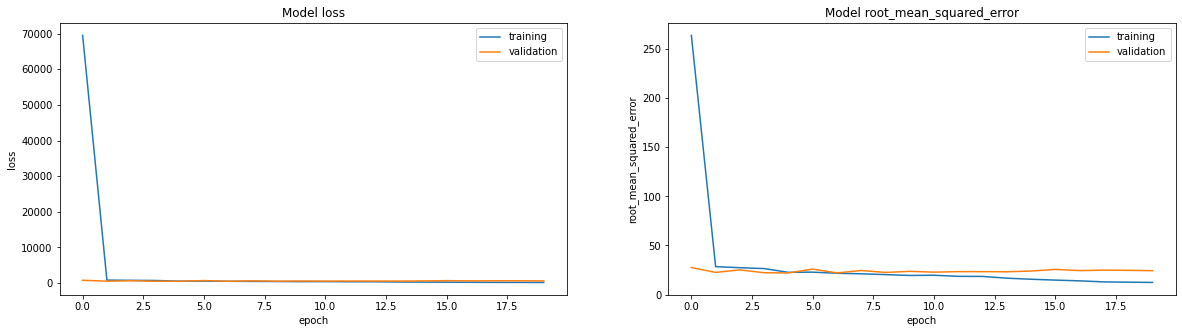

62/62 [==============================] - 1s 8ms/step - loss: 593.0011 - root_mean_squared_error: 24.3516
The validation root mean squared error: 24.351613998413086


In [ ]:
# Create a sequential model
model = models.Sequential()

# Input layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))

# Add max pooling
model.add(layers.MaxPooling2D((2, 2)))

# Add a flatten layer
model.add(layers.Flatten())

# Add a dense layer
model.add(layers.Dense(512, activation='relu'))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.1))

# Add several dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(1, activation=None))

# Use train_and_evaluate to compile the model and evaluate its performance
train_and_evaluate(model, image_train, label_train, image_test, label_test)

# Milestone II

The code below belongs to the model formed for Milestone II. The purpose of this milestone was to expand the model from Milestone I.

The main problem of this model is that it overfits the training data, regardless of a relatively large amount of dropout. 

Epoch 1/16
248/248 [==============================] - 9s 34ms/step - loss: 574.2114 - root_mean_squared_error: 23.9627 - val_loss: 493.2103 - val_root_mean_squared_error: 22.2083
Epoch 2/16
248/248 [==============================] - 8s 33ms/step - loss: 525.2075 - root_mean_squared_error: 22.9174 - val_loss: 509.7028 - val_root_mean_squared_error: 22.5766
Epoch 3/16
248/248 [==============================] - 8s 33ms/step - loss: 505.8639 - root_mean_squared_error: 22.4914 - val_loss: 508.4985 - val_root_mean_squared_error: 22.5499
Epoch 4/16
248/248 [==============================] - 8s 33ms/step - loss: 495.4322 - root_mean_squared_error: 22.2583 - val_loss: 521.4919 - val_root_mean_squared_error: 22.8362
Epoch 5/16
248/248 [==============================] - 8s 33ms/step - loss: 489.0663 - root_mean_squared_error: 22.1148 - val_loss: 485.1063 - val_root_mean_squared_error: 22.0251
Epoch 6/16
248/248 [==============================] - 8s 33ms/step - loss: 489.3503 - root_mean_squared_e

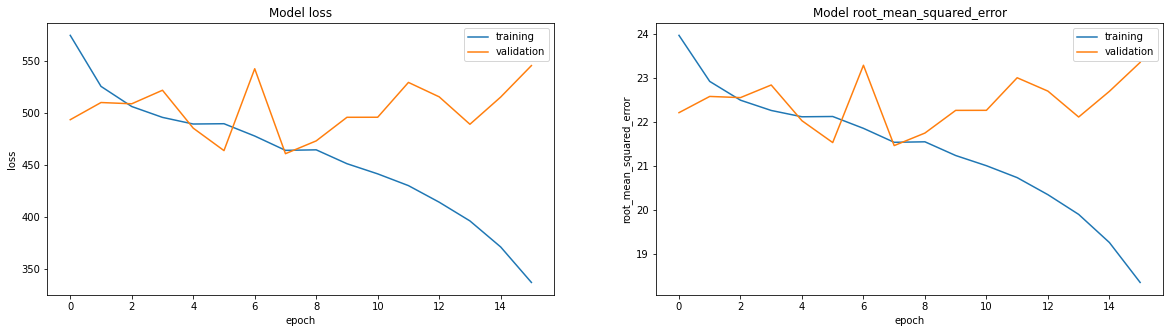

62/62 [==============================] - 1s 11ms/step - loss: 545.1712 - root_mean_squared_error: 23.3489
The validation root mean squared error: 23.348901748657227


In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling 
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())

# Add a third layer
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a fourth layer
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a flatten layer
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(512,activation='relu'))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256,activation='relu'))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128,activation='relu'))

# Output layer
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# Use train_and_evaluate to compile the model and evaluate its performance
train_and_evaluate(model, image_train, label_train, image_test, label_test, preprocess, epochs=16)

# Milestone III
The code for this milestone corresponds to two different models.

The first model is an extension of the convolutional neural network with L2  regularization for the purpose of reducing overfit. This aim was obtained, yet not succesfully, as the model seems to underfit the data now.

The second model is a convolutional neural network combined with tabular data. A potential problem of this model is the possibility that the tabular data is dense enough for the network to form a prediction, implying that the model will not train its convolutional part until its tabular branch is completely done training. 

### The Convolutional Neural Network

Epoch 1/60
248/248 [==============================] - 20s 39ms/step - loss: 1191.9465 - root_mean_squared_error: 31.2214 - val_loss: 1362.1876 - val_root_mean_squared_error: 36.6501
Epoch 2/60
248/248 [==============================] - 8s 34ms/step - loss: 1026.6051 - root_mean_squared_error: 29.3087 - val_loss: 1317.5485 - val_root_mean_squared_error: 35.7676
Epoch 3/60
248/248 [==============================] - 9s 34ms/step - loss: 1012.2349 - root_mean_squared_error: 29.3370 - val_loss: 1315.5690 - val_root_mean_squared_error: 35.7087
Epoch 4/60
248/248 [==============================] - 9s 34ms/step - loss: 976.7995 - root_mean_squared_error: 28.9727 - val_loss: 1241.2720 - val_root_mean_squared_error: 34.7422
Epoch 5/60
248/248 [==============================] - 9s 35ms/step - loss: 940.2780 - root_mean_squared_error: 28.5927 - val_loss: 1208.8534 - val_root_mean_squared_error: 34.4036
Epoch 6/60
248/248 [==============================] - 9s 34ms/step - loss: 906.3970 - root_mean_

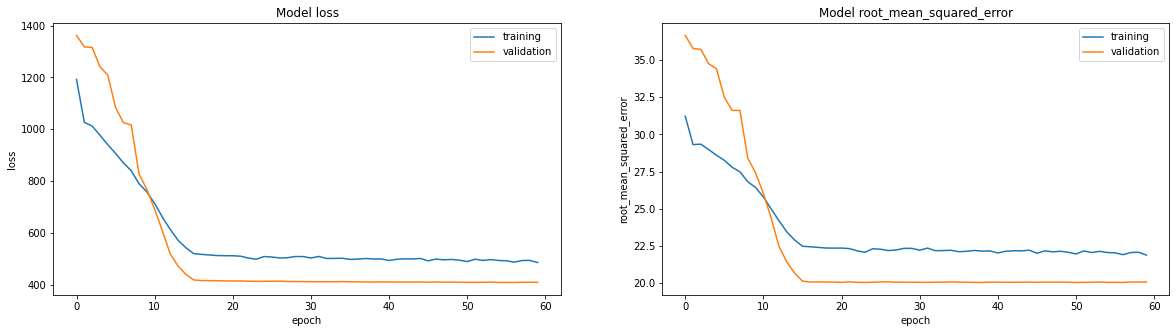

62/62 [==============================] - 1s 12ms/step - loss: 408.9433 - root_mean_squared_error: 20.0665
The validation root mean squared error: 20.06652069091797


In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.3))

# Add the second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third layer 
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth layer, without dropout
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add the flatten layer 
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))

# Output layer
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Use train_and_evaluate to compile the model and evaluate its performance
train_and_evaluate(model, image_train, label_train, image_test, label_test, preprocess=preprocess, epochs=60)

### The Combined Convolutional and Tabular Network
Though it has not been used in any version of the model thus far, a set of tabular data was provided in addition to the image data. Adding this data to the model is a potential way of enhancing the performance of the model. The tabular branch of the neural network was concatenated with the convolutional branch before the output layer in the network.

For the combined convolutional and tabular network the tabular data is transfomed in a numpy array

#### Define A New Function to train and evaluate
A new function to train and evaluate the model is needed now, because the model combining the image data and the tabular data handles the data slightly differently. 

In [ ]:
def combined_tabular_train_and_evaluate(model, train_x, train_y, val_x, val_y, tabular_train, tabular_test, preprocess={}, epochs=20, augment={}):
    """ This function takes data regarding training samples and validation 
    samples for both image data as well as tabular data, and compiles the model 
    using the Mean Squared Error loss function and the Adam optimizer. It evaluates the performance of 
    the model using the Root Mean Squared Error. It is possible to pass arguments 
    for preprocessing of samples and data augmentation. The number of epochs is 20 by default. """

    # Compile the model using adam as optimizer with mean squared error as loss function
    model.compile(optimizer='adam',
              loss='MSE',
              metrics=['RootMeanSquaredError'])

    # Use ImageDataGenerator to preprocess the samples or apply data augmentation
    train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(val_x)

    # Fit the model using the train and validation data 
    history = model.fit(train_gen.flow((train_x, tabular_train), train_y), epochs=epochs, 
                        validation_data=val_gen.flow((val_x, tabular_test), val_y))

    # Make the figure for two plots
    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    # Plot the learning curves
    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

#### Making a new model with layers for image and tabular data

In [ ]:
# Create the convolutional branch of the model for the images 
model_img = tf.keras.Input(shape = image_train.shape[1:], name = 'IMG')

# Add the first convolutional layer 
model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu' ,padding='same', name = 'IMG_1')(model_img)

# Add max pooling
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

# Add the second layer
model_img_3 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_2)
model_img_4 = tf.keras.layers.MaxPool2D((2,2))(model_img_3)

# Add batchnormalization
model_img_5 = tf.keras.layers.BatchNormalization()(model_img_4)

# Add the third layer
model_img_6 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_5)
model_img_7 = tf.keras.layers.MaxPool2D((2,2))(model_img_6)
model_img_8 = tf.keras.layers.BatchNormalization()(model_img_7)

# Add dropout before the fourth layer
model_img_9 = tf.keras.layers.Dropout(0.1)(model_img_8)
model_img_10 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same')(model_img_9)
model_img_11 = tf.keras.layers.MaxPool2D((2,2))(model_img_10)
model_img_12 = tf.keras.layers.BatchNormalization()(model_img_11)

# Add the flatten layer
model_img_13 = tf.keras.layers.Flatten()(model_img_12)

# Add dropout before several dense layers
model_img_14 = tf.keras.layers.Dropout(0.4)(model_img_13)
model_img_15 = tf.keras.layers.Dense(512,activation='relu')(model_img_14)

model_img_16 = tf.keras.layers.Dropout(0.4)(model_img_15)
model_img_17 = tf.keras.layers.Dense(256,activation='relu')(model_img_16)

model_img_18 = tf.keras.layers.Dropout(0.4)(model_img_17)
model_img_19 = tf.keras.layers.Dense(128,activation='relu')(model_img_18)

model_img_20 = tf.keras.layers.Dropout(0.4)(model_img_19)

# Create the tabular branch of the model using dense layers
model_tabular = tf.keras.Input(shape = tabular.shape[1:], name = 'model_tabular') 
model_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='model_tabular1')(model_tabular)
model_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='model_tabular2')(model_tabular1)
model_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='model_tabular3')(model_tabular2)
model_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='model_tabular4')(model_tabular3)

# Create the layer to concatenate the branches
model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([model_tabular4, model_img_20])

# Output layer
model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_concat)

# Combine the branches model image and tabular model in the model
model = tf.keras.Model(inputs = [model_img, model_tabular], outputs = model_fin)

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# Train the model and evaluate the model with the test_data
combined_tabular_train_and_evaluate(model, image_train, label_train, image_test, label_test, tabular_train, tabular_test, preprocess, epochs=20)

# Milestone IV

In milestone IV we looked at different optimizers, made changes to our tabular model, we used data augmentations and we used k-fold to look for the optimal model. 

## Optimizers
First we need to define new train and evaluate functions one with the SGD optimizer and one with the FTLR optimizer and than we can run 2 basic models from mile stone II

In [ ]:
def train_and_evaluate_SGD(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    """ This function compiles a model on samples (train_x) and their 
    labels (train_y), using the Mean Squared Error loss function and the Adam optimizer. 
    Additionally, it evaluates the performance of the model on validation data 
    (val_x and val_y) using the Root Mean Squared Error. It is possible to pass arguments 
    for preprocessing of samples and data augmentation. The number of epochs is 20 by default. """

    opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
    # Use compile to compile the model
    model.compile(loss='mse', optimizer=opt, metrics=['RootMeanSquaredError'])

    # Use ImageDataGenerator to preprocess the samples or apply data augmentation
    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    # Fit the model using the train and validation data
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    # Make the figure for two plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

    # Plot the learning curves (loss and root mean squared error) of the train and validation 
    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    # Display the validation root mean squared error after training
    print(f"The validation root mean squared error: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

In [ ]:
def train_and_evaluate_FTRL(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    """ This function compiles a model on samples (train_x) and their 
    labels (train_y), using the Mean Squared Error loss function and the Adam optimizer. 
    Additionally, it evaluates the performance of the model on validation data 
    (val_x and val_y) using the Root Mean Squared Error. It is possible to pass arguments 
    for preprocessing of samples and data augmentation. The number of epochs is 20 by default. """

    # Use compile to compile the model
    model.compile(loss='mse', optimizer='ftrl', metrics=['RootMeanSquaredError'])

    # Use ImageDataGenerator to preprocess the samples or apply data augmentation
    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    # Fit the model using the train and validation data
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    # Make the figure for two plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

    # Plot the learning curves (loss and root mean squared error) of the train and validation 
    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    # Display the validation root mean squared error after training
    print(f"The validation root mean squared error: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.3))

# Add the second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third layer 
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth layer, without dropout
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add the flatten layer 
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))

# Output layer
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Use train_and_evaluate to compile the model and evaluate its performance
train_and_evaluate_SGD(model, image_train, label_train, image_test, label_test, preprocess=preprocess, epochs=20)

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.3))

# Add the second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third layer 
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth layer, without dropout
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add the flatten layer 
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))

# Output layer
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Use train_and_evaluate to compile the model and evaluate its performance
train_and_evaluate_FTRL(model, image_train, label_train, image_test, label_test, preprocess=preprocess, epochs=20)

## Train and evaluate method with K-fold
For the last milestone, K-fold cross validation was introduced to evaluate and compare the different models. The train and evaluate function was altered accordingly, as seen below.

In [ ]:
def kfold_train_and_evaluate(model, train_x, train_y, preprocess={}, epochs=20, augment={}, folds = 5):
    """ This function compiles a model on samples (train_x) and their 
    labels (train_y), using the Mean Squared Error loss function and the Adam optimizer. 
    Additionally, it evaluates the performance of the model on validation data 
    (val_x and val_y) using the Root Mean Squared Error. Furthermore, K_fold cross_validation
    is implemented for a given number of folds. It is possible to pass arguments 
    for preprocessing of samples and data augmentation. The number of epochs is 20 by default.  """

    kfold = KFold(n_splits=folds)

    # Define an empty list to store the cv scores of every fold
    cv_scores= [] 

    # Create a for_loop to fit the model for every fold
    for train, test in kfold.split(train_x, train_y):

      # Compile the model using adam as optimizer with mean squared error as loss function
        model.compile(optimizer='adam',
                loss='MSE',
                metrics=['RootMeanSquaredError'])

        # Use ImageDataGenerator to preprocess the samples or apply data augmentation
        train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
        train_gen.fit(train_x[train]) 

        val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
        val_gen.fit(train_x[test])

        # Fit the model using compile 
        history = model.fit(train_gen.flow(train_x[train], np.array(train_y)[train]), epochs=epochs, 
                          validation_data=val_gen.flow(train_x[test], np.array(train_y)[test]))

        # Create a figure for two plots
        fig, axs = plt.subplots(1,2,figsize=(20,5)) 

      # Plot the learning curves
        for i, metric in enumerate(['loss', 'root_mean_squared_error']):
            axs[i].plot(history.history[metric])
            axs[i].plot(history.history['val_'+metric])
            axs[i].legend(['training', 'validation'], loc='best')

            axs[i].set_title('Model '+metric)
            axs[i].set_ylabel(metric)
            axs[i].set_xlabel('epoch')

        plt.show()

        # Evaluate the model to get the score for a single fold 
        score = model.evaluate(val_gen.flow(train_x[test], np.array(train_y)[test]))[1]

        # Store the score 
        cv_scores.append(score)

    # Look at the sample scores
    print('cv_scores:', cv_scores)
    
    # Display the mean root mean squared error across K folds
    print('Mean RMSE:', np.mean(cv_scores))

## Network with augmentation
The number of samples to train the model (7929) is rather small for an image regression task. For this reason, data augmentation was used to artificially increase the data and avoid overfitting.  (Volgens mij hoeft deze er helemaal niet tussen te staan?)

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Add the first convolutional layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add maxpooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add dropout 
model.add(tf.keras.layers.Dropout(0.3))

# Add the second convolutional layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third convolutional layer
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth convolutional layer without dropout, but with L2 regularization
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a flatten layer
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))

# Implement L2 regularization in the second to last dense layer
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))
model.add(tf.keras.layers.Dropout(0.7))

# Output layer 
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the data 
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Add augment to apply data augmentation
augment = {'rotation_range' : 30 , 'vertical_flip' : True, 'width_shift_range' : 0.25, 'height_shift_range' : 0.25}

# train the model and evaluate the model with the test_data
kfold_train_and_evaluate(model, images, image_labels, preprocess=preprocess, epochs=20, augment = augment)

## Altering the network structure

To reduce the need for a heavy amount of dropout in the earlier model, the ReLu activation function was modified. Instead, the Leaky ReLu activation function was used in all layers. 
To increase the complexity of the model, fully connected convolutional layers were added with the purpose of allowing the model to extract more complex features from the dataset.
Augmentation was also implemented in this deeper network.

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Add the first fully connected convolutional layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='leaky_relu',input_shape=(64,64,3),padding='same'))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='leaky_relu',padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add dropout
model.add(tf.keras.layers.Dropout(0.2))

# Add the second group of fully connected convolutional layers with max pooling
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())

# Add dropout 
model.add(tf.keras.layers.Dropout(0.2))

# Add the third group of fully connected convolutional layers
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

# Add the fourth group of fully connected convolutional layers, without dropout, yet with L2 regularization
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='leaky_relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a flatten layer
model.add(tf.keras.layers.Flatten())

# Implement L2 regularizartion and dropout
model.add(tf.keras.layers.Dense(256, activation='leaky_relu', activity_regularizer=regularizers.l2(1e-1)))
model.add(tf.keras.layers.Dropout(0.5))

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(128,activation='leaky_relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(64,activation='leaky_relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Output layer
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the data
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Add augment to apply data augmentation
augment = {'rotation_range' : [-10,10], 'vertical_flip' : True, 'width_shift_range' : 8, 'height_shift_range' : 8}

# train the model and evaluate it with the test_data
kfold_train_and_evaluate(model, images, image_labels, preprocess=preprocess, epochs=5, augment = augment)

## Combined tabular and image model
This model combines the tabular and image models after flattening the convolution data. This way the convolution data will be more intertwined because of the dense layers.

This should result in a more even distribution of what data the model deems important. The main problem of this model is that it seems to generate the average score as the output, regardless of its input. 

Also the original size of the image is added to the tabular data.

In [ ]:
# Create the convolutional branch of the model for the images 
model_img = tf.keras.Input(shape = image_train.shape[1:])

# Add the first convolutional layer
model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)

# Add max pooling
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

# Add dropout 
model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)

# Add the second convolutional layer 
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)

# Add batchnormalization
model_img_6 = layers.BatchNormalization()(model_img_5)
model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)

# Add the third convolutional layer
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)
model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)

# Add the fourth convolutional layer
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-2))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)

# Add the flatten layer
model_img_15 = tf.keras.layers.Flatten()(model_img_14)

# Create the tabular branch of the model using dense layers
model_tabular = tf.keras.Input(shape = tabular_IV.shape[1:], name = 'tabular') 
model_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='tabular1')(model_tabular)
model_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='tabular2')(model_tabular1)
model_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='tabular3')(model_tabular2)
model_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='tabular4')(model_tabular3)

# Create the layer to concatenate the branches
model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([model_tabular4, model_img_15])

# Add several more dense layers with dropout
model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_concat)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)

model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)

model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-2))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.6)(model_img_20)

# Output layer
model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_img_21)

# Combine the branches model image and tabular model in the model 
model = tf.keras.Model(inputs = [model_img, model_tabular], outputs = model_fin)

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Train the model and evaluate the model with the test_data
combined_tabular_train_and_evaluate(model, image_train, label_train, image_test, label_test, tabular_IV_train, tabular_IV_test, preprocess, epochs=20)

### Problem with tabular data

We can see below that the addition of tabular data does not help our model. The model just picks a single value and gives this score to all the images.

In [ ]:
predictions = model.predict([image_test, tabular_test])
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(predictions)
plt.title('Test predictions')
plt.xlabel("Pawpularity score")
plt.show()

pred_plot = sns.boxplot(predictions)

pred_plot.set(xlim=(-1, 102))
plt.title('Test predictions')
plt.xlabel("Pawpularity score")
plt.show()

data_plot = sns.boxplot(label_test)
data_plot.set(xlim=(-1, 102))
plt.title('Test scores')
plt.xlabel("Pawpularity score")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


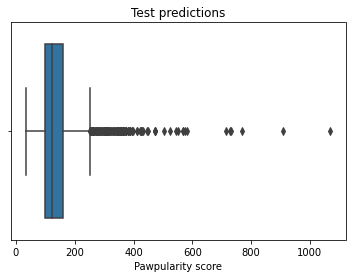

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


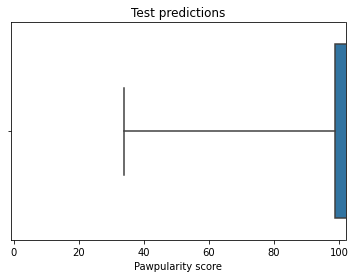

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


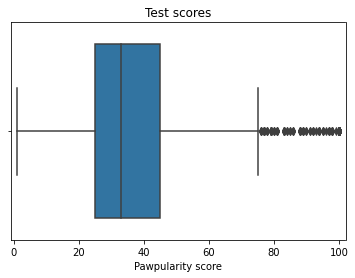

In [ ]:
predictions = model.predict([image_test, tabular_test])
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(predictions)
plt.title('Test predictions')
plt.xlabel("Pawpularity score")
plt.show()

pred_plot = sns.boxplot(predictions)

pred_plot.set(xlim=(-1, 102))
plt.title('Test predictions')
plt.xlabel("Pawpularity score")
plt.show()

data_plot = sns.boxplot(label_test)
data_plot.set(xlim=(-1, 102))
plt.title('Test scores')
plt.xlabel("Pawpularity score")
plt.show()

32.57717336874411
